# 3 - Logistic Regression from Scratch

In this tutorial we are doing logistic regression, more specifically binary logistic regression. That all sounds like a load of jargon, but to put it in plain English: logistic regression involves classifying a set of examples into one of $N$ classes. Binary logistic regression is a special case of logistic regression in which we only have two classes. 

We are going to create logistic regressor that can correctly classify if a point belongs to class 0 or class 1 from its x, y co-ordinates. Classes are also referred to as labels, i.e. if an example belongs to class 0, we can say it has a label of 0.

Our regressor will use 3 parameters to predict the class. These predictions will be in the form of a real number between 0 and 1. The initial parameters will give poor predictions, but we update them using *gradient descent* in order to improve our performance.

First, we'll import our libraries, `matplotlib` for plotting and `numpy` its functionality.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

We'll set `numpy`'s random seed to ensure the notebook is deterministic.

In [2]:
np.random.seed(1)

Now we'll generate the points that make up our dataset. 

In this toy example we are going draw examples from a 2-dimensional space. Examples from class 0 will have their x and y co-ordinates both be drawn from a Gaussian distribution with a mean of 3 and class 1 will have their examples drawn examples from a Gaussian with a mean of 6. 

This basically means all examples in class 0 are centered around the point $(3,3)$ and all examples in class 1 are centered around $(6, 6)$. 

We'll generate 1000 examples of each class. 

In [3]:
x0s = np.random.normal(loc=3, size=(1000, 2))
y0s = np.zeros(1000)
x1s = np.random.normal(loc=6, size=(1000, 2))
y1s = np.ones(1000)

We concatenate the examples from each class together into a single `numpy` array.

In [4]:
xs = np.concatenate((x0s, x1s))
ys = np.concatenate((y0s, y1s))

Thus, our data, `xs`, is represented by a $(2000,2)$ matrix, where the first column, `xs[:,0]`, holds the x co-ordinates of the examples, while the second column, `xs[:,1]`, holds the y co-ordinates of the examples. 

Our labels, `y`, are a $2000$-dimensional vector, with each element being either 0 or 1, to denote which class the corresponding `xs` example belongs to, i.e. the label for `xs[0]` is `y[0]`.

Next, we'll plot the data to see what it looks like, with examples from class 0 in purple and examples from class 1 in yellow. 

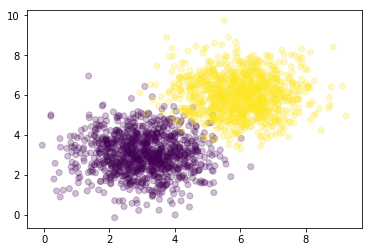

In [5]:
plt.scatter(xs[:,0], xs[:,1], c=ys, alpha=0.25)
plt.show()

Next, we define our error function (also called a loss function). This is a function that calculates how "good" or "far away" our predictions are from the correct class, which is known as the *error* or *loss*. This will be used to tell us how much we need to update our parameters during gradient descent. If our error is small, we only change the parameters a small amount, whereas if the error is large, they need to be changed by a larger amount.

Unlike linear regression where we used mean squared error (MSE), here we'll use cross-entropy loss.

The equation for cross-entropy loss of example $n$ is given by:

$$e_n = - y_n \log(\hat{y_n}) - (1 - y_n) \log(1 - \hat{y_n})$$

$y_n$ denotes the label for example $n$, $\hat{y_n}$ (pronounced "y hat") denotes regressor's prediction for example $n$ and $\log$ denotes the natural logarithm.

Look at the case when the label ($y_n$) is 0, the loss equation simplifies to:

$$e_0 = - \log(1 - \hat{y_n})$$

When we are correct, ($\hat{y_n} = 0$), then we will have:

$$e_0 = - \log(1) = 0$$

Zero error when we are perfectly correct! However, if we are incorrect ($\hat{y_n} \ne 0$), then $e_0$ gets larger the further away $\hat{y_n}$ is from $y$.

Looking at the case when the label is 1, the loss equation becomes:

$$e_1 = - \log(\hat{y_n})$$

When we are correct, ($\hat{y_n} = 1$), then we have:

$$e_1 = - \log(1) = 0$$

Again, a zero error. Like before, the further away $\hat{y_n}$ is from 1, the larger the error.

In [62]:
def calc_error(y_hat, y, eps=1e-10):
    """
    Cross-entropy loss between labels, y, and predictions, y_hat 
    """
    error = - y * np.log(y_hat + eps) - (1 - y) * np.log(1 - y_hat + eps)
    return error

In the equations above, when $y = 0$ then we could ignore the whole $-y\log(\hat{y})$ term, however Python will try to calculate each term in the loss equation without simplifying. In the case where $\hat{y}=0$, this will cause Python to try and calculate $\log(0)$, which is $\infty$, which causes some warnings. 

To avoid this, we use a small epsilon term $\epsilon$, `eps`. This very small number is just used to ensure that we never try and calculate $\log(0)$.

To check that it works, let's try check when $\hat{y} = y$. From above, we're expecting a small number, however because of the `eps` term, we will never actually get value of 0.

In [69]:
print(calc_error(0, 0))
print(calc_error(1, 1))

-1.000000082690371e-10
-1.000000082690371e-10


That's definitely a small number! Unlike MSE, cross-entropy loss can go negative, especially when the predictions are very close to the labels. This doesn't really matter though, we are still trying to minimize the loss function so the more negative we can get it, the better!

We'll define another function that averages the loss across all examples.

In [8]:
def calc_errors(y_hats, ys):
    """
    Calculates the average error between a list of predictions, y_hats
    and a list of labels, ys.
    """
    error = np.mean([calc_error(y_hat, y) for y_hat, y in zip(y_hats, ys)])
    return error

Unlike linear regression where the output is an unbounded real number, in binary regression the output is a real number bound between $[0,1]$ as you are trying to predict the class/label of the example. 

You can think of the real number output by the regressor as an indication of how strongly it believes this example should belong to a certain class, i.e. if the regressor outputs 0.1 it's pretty certain this example belongs to class 0 and if it outputs 0.6 it's not really sure, but leaning towards class 1.

How do we bound the output between $[0,1]$? We use a *sigmoid* function, which looks like this:

![](assets/sigmoid.png)

Large positive and negative values cause it to output approx. 1 and 0, respectively.

The equation for the sigmoid function is given by:

$$\sigma(x) = \frac{1}{1 + e^{-x}}$$

We can easily implement this in Python:

In [9]:
def sigmoid(x):
    return 1 / (1 + np.e ** -x)

And to verify we have implemented it correctly:

In [10]:
print(f'sigmoid(large positive) = {sigmoid( 100)}')
print(f'sigmoid(large negative) = {sigmoid(-100)}')

sigmoid(large positive) = 1.0
sigmoid(large negative) = 3.7200759760208555e-44


Next, we'll define the variables of our regressor. Our regressor has two inputs, the x co-ordinate and the y co-ordinate, which we denote $x_0$ and $x_1$. We'll use one parameter for each, $w_0$ and $w_1$, along with a bias term, $b$. The output of our regressor is a weighted sum of the inputs and parameters, plus a bias term, and fed through the sigmoid function to give us an output $[0,1]$.

$$\hat{y} = \sigma ( w_0 x_0 + w_1 x_1 + b)$$

Commonly you will see the weighted sum terms denoted by $z$:

$$z = w_0 x_0 + w_1 x_1 + b$$

Therefore, we can also write:

$$\hat{y} = \sigma(z)$$

Let's define our initial values for $w_0, w_1, b$.

In [11]:
pred_w0 = np.random.normal()
pred_w1 = np.random.normal()
pred_b = np.random.normal()

Next, we'll write a function that takes an example in and uses the current $w_0, w_1, b$ values to make a prediction.

As well as measuring the loss of the regression, we also want to see how accurate it is. To do this we must categorize each of the real value predictions between 0 and 1 into a class. 

The simplest way to do this is to say any values $\ge 0.5$ belong to class 1, and any $\lt 0.5$ belong to class 0.

Our `predict` function calculates and returns both the real value as well as the predicted class.

In [12]:
def predict(pred_w0, pred_w1, pred_b, x):
    pred_val = sigmoid(pred_w0 * x[0] + pred_w1 * x[1] + pred_b)
    pred_class = 1 if pred_val >= 0.5 else 0
    return pred_val, pred_class

We'll also define a `predicts` function that returns predictions for all examples. 

The `map(np.array, zip(*...` here is looks a bit complicated, but breaking it down: 
- the list comprehension returns a list of two element tuples (`pred_val`, `pred_class`)
- the `zip(*...` converts the list of tuples into two tuples, one with all the `pred_val` and one with all the `pred_class`
- the `map(np.array, ...` converts the two `pred_val` and `pred_class` tuples into `numpy` arrays 

We want them as `numpy` arrays so we can do certain operations on them.

In [13]:
def predicts(pred_w0, pred_w1, pred_b, xs):
    pred_vals, pred_classes = map(np.array, zip(*[predict(pred_w0, pred_w1, pred_b, x) for x in xs]))
    return pred_vals, pred_classes

Let's use our initial $w_0, w_1, b$ values to make some predictions.

We'll denote the predicted class as $\hat{c}$.

In [14]:
y_hats, c_hats = predicts(pred_w0, pred_w1, pred_b, xs)

We can find out how many of our predicted classes were correct out of the 2000 in our dataset.

We do this by summing the number of times $\hat{c} = y$

In [15]:
n_correct = (c_hats == ys).sum()

print(n_correct)

1012


We can also convert this into an accuracy

In [16]:
accuracy = n_correct / len(c_hats)

print(accuracy)

0.506


50.6% is pretty bad, and is not really any better than random guessing without even looking at the values. 

However, our next function will implement gradient descent, which we'll use to update our parameters and get a much better accuracy.

Let's remind ourself of some equations:

$$z = w_0 x_0 + w_1 x_1 + b$$

$$\hat{y} = \sigma (z)$$

$$e = - y \log(\hat{y}) - (1 - y) \log(1 - \hat{y})$$

Looking at a single parameter in our regressor, $w_0$, we can see how changing $w_0$ will change the value of $z$, which changes $\hat{y}$, which changes $e$.

We want to find how much to change $w_0$ to reduce $e$, as our main goal is reducing the error. We can imagine the relationship between $w_0$ and $e$ as something like:

![](assets/gd1.png)

That is, there is some optimal value of $w_0$ which gives us the minimum $e$ we can achieve. 

In reality, the values of $w_1$ and $b$ interact with $w_0$ to find the minimum $e$, however for the purpose of this explanation we'll assume that $w_1$ and $b$ are fixed and $w_0$ is the only parameter we can change.

When we randomly initialize $w_0$, it starts at some point on this graph. We show this in red below:

![](assets/gd2.png)

We want to end up at the lowest point in the graph, called the global minimum, as this gives us the lowest error. We do this by taking small steps and *descending* the graph, following the *gradient* (the slope of the graph), i.e. gradient descent! We can also think of the gradient/slope as the rate of change between the two values, i.e. when the graph is steep the rate of change between them is high as $w_0$ changes only a little, whilst $e$ changes a lot more.

Thus, we want to calculate the gradient of $e$ with respect to $w_0$ to give us something like the graph above. Once we have this, we can calculate the gradient of our current $w_0$ value, which gives us both the steepness of the slope $w_0$ is currently on, and also tells us if the slope is going up or down.

The steepness of the slope (the magnitude of the gradient) is used to tell us how big of a step we take. If we are on a very steep slope then we can take a large step as we can assume we are not near the minimum. As the slope gets flatter we assume we are closer to the minimum and thus take smaller steps to avoid stepping over the minimum.

The direction of the slope (the sign of the gradient) tells us which direction to walk in. If the gradient is negative, i.e. pointing "downwards" like the left hand side of the figures above, then we increase $w_0$. If the gradient is positive, i.e. pointing "upwards" like the right hand side of the figures above, then we need to decrease $w_0$. 

After we have calculated the gradient of our current $w_0$, we take a single step towards the minimum, recalculate the gradient, and then take another step. We repeatedly take steps until we have reached the minimum point of the graph.

![](assets/gd3.png)

How do we actually calculate gradients? We calculate the gradient of $e$ with respect to $w_0$ by taking the *derivative* of $e$ with respect to $w_0$ (you can also say *differentiate* $e$ with respect to $w_0$) and it is denoted by:

$$\frac{\partial e}{\partial w_0}$$

We're going to go deep into exactly how to differentiate functions, so if you don't know how to calculate them I'd suggesting doing the [Khan Academy track](https://www.khanacademy.org/math/calculus-home/taking-derivatives-calc). If you don't know how they work, all you need to know is that the derivative of a function with respect to a variable is the gradient/slope of the function with respect to that variable.

Finding $\frac{\partial e}{\partial w_0}$ isn't as straightforward as you might think. As already stated, changing $w_0$ also changes $z$, which changes $\hat{y}$, which changes $e$. Thus, to calculate the gradient between $e$ and $w_0$ we need to calculate the gradients between: $z$ and $w_0$, $\hat{y}$ and $z$, $e$ and $z$. These gradients are also calculated by taking their derivatives. We can re-write $\frac{\partial e}{\partial w_0}$ in terms of the products of each of the derivatives:

$$\frac{\partial e}{\partial w_0} = \frac{\partial e}{\partial \hat{y}} * \frac{\partial \hat{y}}{\partial z} * \frac{\partial z}{\partial w_0} $$

If we can calculate the three terms on the right, we'll have found the gradient of $e$ with respect to $w_0$ and can then use this gradient to update our $w_0$.

First, $\frac{\partial e}{\partial \hat{y}}$. This is how much the cross-entropy loss changes with respect to the prediction, we calculate this by taking the derivative of $e$ with respect to $\hat{y}$.

\begin{align}
\frac{\partial e}{\partial \hat{y}} &= \frac{\partial}{\partial \hat{y}} - y \log(\hat{y}) - (1 - y) \log(1 - \hat{y})\\[0.5ex]
&= - \frac{\partial}{\partial \hat{y}}y \log(\hat{y}) + (1 - y) \log(1 - \hat{y})\\[0.5ex]
&= - (\frac{\partial}{\partial \hat{y}} y \log(\hat{y}) +  \frac{\partial}{\partial \hat{y}}(1 - y) \log(1 - \hat{y}))\\[0.5ex]
&= -(\frac{y}{\hat{y}} - \frac{1-y}{1-\hat{y}})\\[0.5ex]
&= -\frac{y}{\hat{y}} + \frac{1-y}{1-\hat{y}}\\[0.5ex]
&= -\frac{y(1-\hat{y})}{\hat{y}(1-\hat{y})} + \frac{\hat{y}(1-y)}{\hat{y}(1-\hat{y})}\\[0.5ex]
&= \frac{-y(1-\hat{y}+(1-y)\hat{y}}{\hat{y}(1-\hat{y})}\\[0.5ex]
&= \frac{-y + y\hat{y} + \hat{y} - y\hat{y}}{\hat{y}(1-\hat{y})}\\[0.5ex]
&= \frac{\hat{y}-y}{\hat{y}(1-\hat{y})}
\end{align}

Second, $\frac{\partial \hat{y}}{\partial z}$ is the rate of change between the output of the sigmoid function with respect to its input. This is done by taking the derivative of the sigmoid function:

\begin{align}
\frac{\partial \hat{y}}{\partial z} &= \frac{\partial }{\partial z} \sigma (z) \\[0.5ex]
&= \frac{\partial }{\partial z} \frac{1}{1+e^{-z}} \\[0.5ex]
&= \frac{e^{-z}}{(1+e^{-z})^2}\\[0.5ex]
&= \frac{1+e^{-z}-1}{(1+e^{-z})^2}\\[0.5ex]
&= \frac{1+e^{-z}}{(1+e^{-z})^2} - (\frac{1}{1+e^{-z}})^2\\[0.5ex]
&= \frac{1}{(1+e^{-z})} - (\frac{1}{1+e^{-z}})^2\\[0.5ex]
&= \sigma (z) - \sigma (z)^2\\[0.5ex]
&= \sigma (z) (1 - \sigma (z))\\[0.5ex]
&= \hat{y} (1 - \hat{y}) 
\end{align}

Finally, $\frac{\partial z}{\partial w_0}$ is the derivative of the weighted sum with respect to $w_0$.

\begin{align}
\frac{\partial z}{\partial w_0} &= \frac{\partial }{\partial z} w_0 x_0 + w_1 x_1 + b \\[0.5ex]
&= x_0 \\
\end{align}

Thus, the gradient of $e$ with respect to $w_0$ is:

\begin{align}
\frac{\partial e}{\partial w_0} &= \frac{\partial e}{\partial \hat{y}} * \frac{\partial \hat{y}}{\partial z} * \frac{\partial z}{\partial w_0} \\[0.5ex]
&= \frac{\hat{y}-y}{\hat{y}(1-\hat{y})} * \hat{y} (1 - \hat{y}) * x_0 \\[0.5ex]
&= (\hat{y}-y) * x_0
\end{align}

We calculate average gradient value over all of our $N$ examples and use it to update $w_0$. We update $w_0$ as:

$$w_0 = w_0 - (\eta * \frac{\partial e}{\partial w_0})$$

$\eta$ is called the *learning rate*, it is used to control the how much we update $w_0$. If your $\eta$ value is too small, your parameter updates will be tiny and your loss will take forever to minimize. If the value of $\eta$ is too big then the parameter updates will be huge and you may step over the minimum. The value of $\eta$ depends on the task but is usually around $10^{-1}$ and $10^{-4}$.

We are subtracting the $\eta * \frac{\partial e}{\partial w_0}$ term from $w_0$ as we are *descending* the gradient. Remember, if the gradient is positive it is pointing upwards, but we want to go downwards towards the minimum.

To find out how much we need to change $w_1$, we take the derivative of $e$ with respect to $w_1$. Similar to before, we calculate this as:

$$\frac{\partial e}{\partial w_1} = \frac{\partial e}{\partial \hat{y}} * \frac{\partial \hat{y}}{\partial z} * \frac{\partial z}{\partial w_1}$$

Both $\frac{\partial e}{\partial \hat{y}}$ and $\frac{\partial \hat{y}}{\partial z}$ are the exact same as before. We only need to calculate $\frac{\partial z}{\partial w_1}$:

\begin{align}
\frac{\partial z}{\partial w_1} &= \frac{\partial }{\partial z} w_0 x_0 + w_1 x_1 + b \\[0.5ex]
&= x_1 \\
\end{align}

Therefore, the gradient for $w_1$ is:

\begin{align}
\frac{\partial e}{\partial w_1} &= \frac{\partial e}{\partial \hat{y}} * \frac{\partial \hat{y}}{\partial z} * \frac{\partial z}{\partial w_1} \\[0.5ex]
&= \frac{\hat{y}-y}{\hat{y}(1-\hat{y})} * \hat{y} (1 - \hat{y}) * x_1 \\[0.5ex]
&= (\hat{y}-y) * x_1
\end{align}

For updating $b$, again $\frac{\partial e}{\partial \hat{y}}$ and $\frac{\partial \hat{y}}{\partial z}$ are the same. The only difference is $\frac{\partial z}{\partial b}:

\begin{align}
\frac{\partial z}{\partial b} &= \frac{\partial }{\partial z} w_0 x_0 + w_1 x_1 + b \\[0.5ex]
&= 1 \\
\end{align}

The gradient for $b$ is:

\begin{align}
\frac{\partial e}{\partial b} &= \frac{\partial e}{\partial \hat{y}} * \frac{\partial \hat{y}}{\partial z} * \frac{\partial z}{\partial b} \\[0.5ex]
&= \frac{\hat{y}-y}{\hat{y}(1-\hat{y})} * \hat{y} (1 - \hat{y}) * 1 \\[0.5ex]
&= (\hat{y}-y) * 1\\[0.5ex]
&= (\hat{y}-y)
\end{align}

$w_1$ and $b$ are updated as:

\begin{align}
w_1 &= w_1 - (\eta * \frac{\partial e}{\partial w_1})\\[0.5ex]
b &= b - (\eta * \frac{\partial e}{\partial b})
\end{align}

We implement this in code below. `gradient_step` calculates the gradients for every example, averaging them across all examples, and then performs a parameter update. As $\frac{\partial e}{\partial \hat{y}}$ and $\frac{\partial \hat{y}}{\partial z}$ can be simplified together they are combined into a single `dedz` variable.

In [ ]:
def gradient_step(pred_w0, pred_w1, pred_b, xs, ys, eta=0.1):
    """
    Performs one gradient descent step using all of the data points
    pred_w0 (float): predicted w0 value
    pred_w1 (float): predicted w1 value
    pred_b (float): predicted b value
    xs (ndarray[float,float]): x values for data points
    ys (ndarray[float]): y values for data points
    eta (float): learning rate
    """
    
    N = len(xs)
    grad_w0 = 0
    grad_w1 = 0
    grad_b = 0
    
    for x, y in zip(xs, ys):
        y_hat, _ = predict(pred_w0, pred_w1, pred_b, x)
        #de = (y_hat - y) / (y_hat * (1 - y_hat))
        #dz = y_hat * (1 - y_hat)
        dedz = y_hat - y
        dw0 = x[0]
        dw1 = x[1]
        grad_w0 += (1/N) * dedz * dw0
        grad_w1 += (1/N) * dedz * dw1
        grad_b += (1/N) * dedz
        
    new_w0 = pred_w0 - (eta * grad_w0)
    new_w1 = pred_w1 - (eta * grad_w1)
    new_b = pred_b - (eta * grad_b)
    
    return new_w0, new_w1, new_b

In [ ]:
errors = []
accs = []

for _ in range(500):
    pred_w0, pred_w1, pred_b = gradient_step(pred_w0, pred_w1, pred_b, xs, ys)
    y_hats, c_hats = predicts(pred_w0, pred_w1, pred_b, xs)
    error = calc_errors(y_hats, ys)
    acc = np.equal(c_hats, ys).sum()/len(c_hats)
    accs.append(acc)
    errors.append(error)

In [ ]:
plt.plot(errors)
plt.show()

In [ ]:
plt.plot(accs)
plt.show()

In [ ]:
y_hats, c_hats = predicts(pred_w0, pred_w1, pred_b, xs)

In [ ]:
n_correct = (c_hats == ys).sum()

print(n_correct)

In [ ]:
accuracy = n_correct / len(c_hats)

print(accuracy)

In [ ]:
calc_errors(y_hats, ys)

In [ ]:
incorrect_examples = np.where(np.equal(c_hats, ys) == False)

In [ ]:
incorrect_points = xs[incorrect_examples]

In [ ]:
plt.scatter(xs[:,0], xs[:,1], c=ys, alpha=0.25)
plt.scatter(incorrect_points[:,0], incorrect_points[:,1], c='r', marker='x', alpha=0.75)
plt.show()